In [1]:
import csv
import numpy as np
import pandas as pd

import cv2
from matplotlib import pyplot as plt

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
# remove prefixes
import os
path = '/media/stanislau/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/01_data_cls/'
os.chdir(path)

In [ ]:
tbCallBack = keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [4]:
import scipy.ndimage as ndi

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x,
                    transform_matrix,
                    channel_axis=0,
                    fill_mode='nearest',
                    cval=0.):
    """Apply the image transformation specified by a matrix.

    # Arguments
        x: 2D numpy array, single image.
        transform_matrix: Numpy array specifying the geometric transformation.
        channel_axis: Index of axis for channels in the input tensor.
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.

    # Returns
        The transformed version of the input.
    """
    x = np.rollaxis(x, channel_axis, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(
        x_channel,
        final_affine_matrix,
        final_offset,
        order=0,
        mode=fill_mode,
        cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

def flip_axis(x, axis):
    x = np.asarray(x).swapaxes(axis, 0)
    x = x[::-1, ...]
    x = x.swapaxes(0, axis)
    return x

class BrodatzImageDataGenerator(ImageDataGenerator):
    def random_transform(self, x, seed=None):
        """Randomly augment a single image tensor.

        # Arguments
            x: 3D tensor, single image.
            seed: random seed.

        # Returns
            A randomly transformed version of the input (same shape).
        """
        # x is a single image, so it doesn't have image number at index 0
        img_row_axis = self.row_axis - 1
        img_col_axis = self.col_axis - 1
        img_channel_axis = self.channel_axis - 1

        if seed is not None:
            np.random.seed(seed)

        # use composition of homographies
        # to generate final transform that needs to be applied
        if self.rotation_range:
            theta = np.pi / 180 * np.random.uniform(-self.rotation_range, self.rotation_range)
        else:
            theta = 0

        if self.height_shift_range:
            tx = np.random.uniform(-self.height_shift_range, self.height_shift_range) * x.shape[img_row_axis]
        else:
            tx = 0

        if self.width_shift_range:
            ty = np.random.uniform(-self.width_shift_range, self.width_shift_range) * x.shape[img_col_axis]
        else:
            ty = 0

        if self.shear_range:
            shear = np.random.uniform(-self.shear_range, self.shear_range)
        else:
            shear = 0

        if self.zoom_range[0] == 1 and self.zoom_range[1] == 1:
            zx, zy = 1, 1
        else:
            if np.random.random() < 0.5:
                zx = zy = self.zoom_range[0] + np.random.uniform(-0.05, 0.05)
            else:
                zx = zy = self.zoom_range[1] + np.random.uniform(-0.05, 0.05)

        transform_matrix = None
        if theta != 0:
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                        [np.sin(theta), np.cos(theta), 0],
                                        [0, 0, 1]])
            transform_matrix = rotation_matrix

        if tx != 0 or ty != 0:
            shift_matrix = np.array([[1, 0, tx],
                                     [0, 1, ty],
                                     [0, 0, 1]])
            transform_matrix = shift_matrix if transform_matrix is None else np.dot(transform_matrix, shift_matrix)

        if shear != 0:
            shear_matrix = np.array([[1, -np.sin(shear), 0],
                                    [0, np.cos(shear), 0],
                                    [0, 0, 1]])
            transform_matrix = shear_matrix if transform_matrix is None else np.dot(transform_matrix, shear_matrix)

        if zx != 1 or zy != 1:
            zoom_matrix = np.array([[zx, 0, 0],
                                    [0, zy, 0],
                                    [0, 0, 1]])
            transform_matrix = zoom_matrix if transform_matrix is None else np.dot(transform_matrix, zoom_matrix)

        if transform_matrix is not None:
            h, w = x.shape[img_row_axis], x.shape[img_col_axis]
            transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
            x = apply_transform(x, transform_matrix, img_channel_axis,
                                fill_mode=self.fill_mode, cval=self.cval)

        if self.channel_shift_range != 0:
            x = random_channel_shift(x,
                                     self.channel_shift_range,
                                     img_channel_axis)
        if self.horizontal_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_col_axis)

        if self.vertical_flip:
            if np.random.random() < 0.5:
                x = flip_axis(x, img_row_axis)

        return x

In [5]:
def process_file(path):
    df = pd.read_csv(path)
    
    x = []
    y = []
    filenames = []

    for index, row in df.iterrows():
        x.append(cv2.imread(row[0], cv2.IMREAD_GRAYSCALE))
        y.append(float(row[1]))

    x = np.array(x)
    y = np.array(y)
    
    num_classes = len(np.unique(y))

    x = x.reshape(x.shape + (-1,))
    x = x.astype('float32') / 255
    
    y = y - 1
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return x, y, num_classes

def probas_to_classes(y_prob):
    return np.argmax(y_prob, axis=1) + 1

def accuracy(y_test, y_predict):
    return np.sum(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))/y_predict.shape[0]

def process_file_some_classes(path, classes):
    df = pd.read_csv(path)
    
    x = []
    y = []

    for index, row in df.iterrows():
        x.append(cv2.imread(row['FilePath'], cv2.IMREAD_GRAYSCALE))
        y.append(float(row['ClassId']))

    x = np.array(x)
    y = np.array(y) - 1
        
    num_classes = len(classes)

    x = x.reshape(x.shape + (-1,))
    x = x.astype('float32') / 255
    
    x = x[np.in1d(y, classes)]
    y = y[np.in1d(y, classes)]
    
    y = keras.utils.to_categorical(y, num_classes=num_classes)

    return x, y, num_classes
            

def process_line(line):
    pass

def generate_arrays_from_file(path):
    df = pd.read_csv(path)
    
    while 1:
        f = open(path)
        for line in f:
            # create numpy arrays of input data
            # and labels, from each line in the file
            x1, x2, y = process_line(line)
            yield ({'input_1': x1, 'input_2': x2}, {'output': y})
        f.close()
        
def plot(x):
    plt.imshow(x.reshape(x.shape[:-1]), cmap=plt.cm.gray)
    plt.show()
    
def model_1(num_classes):
    model = Sequential()
    # input: 200x200 grayscale images -> (200, 200, 1) tensors.
    # this applies 8 convolution filters of size 3x3 each.
    model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(200, 200, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
#     model.add(Conv2D(512, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), activation='softmax'), )

#     sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

def fit_1(model, x, y, classes, batch_size=32, epochs=100):
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
    return model.fit(x, y, batch_size=50, epochs=epochs, validation_data=(x_test, y_test))

def fit_generator_1(model, x, y, classes, batch_size=32, epochs=100):
    datagen = ImageDataGenerator(
        rotation_range=40,
        shear_range=0.4,
        width_shift_range=0.6,
        height_shift_range=0.6,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=2,
        fill_mode='reflect')
    
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test2.csv', classes)
    return model.fit_generator(datagen.flow(x, y, batch_size=batch_size), validation_data=(x_test, y_test),
                    steps_per_epoch=len(x) / batch_size, epochs=epochs)

def test_1(model, classes, batch_size=32):
    test_paths = ['Alexander_cls_train.csv',
                 'Alexander_cls_test.csv',
                 'Alexander_cls_test1.csv',
                 'Alexander_cls_test2.csv',
                 'Alexander_cls_test3.csv',
                 'Alexander_cls_test4.csv']

    for test_path in test_paths:
        x_test, y_test, num_classes = process_file_some_classes(test_path, classes)
        score = model.evaluate(x_test, y_test, batch_size=batch_size)
        print(test_path + ' : ' + ', '.join(str(x) for x in score))
        
def pipe_1():
    classes = np.arange(0, 15)
    x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)
    
    model = model_1(num_classes)
    
    batch_size = 50
    epochs = 30
    history = fit_1(model, x, y, classes, batch_size, epochs)
    test_1(model, classes, batch_size)
    return history

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history.get('val_acc')
    loss = history.history['loss']
    val_loss = history.history.get('val_loss')
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss)
    if val_loss is not None:
        plt.plot(epochs, val_loss)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(epochs, acc)
    if val_acc is not None:
        plt.plot(epochs, val_acc)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

def predict_1(model, classes):
    x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test.csv', classes)
    y_predict = model.predict(x_test, batch_size=32)
    
def save_model(model):
    path = '/media/stanislau/82db778e-0496-450c-9b25-d1e50a90e476/data/data4stas/brodaz'
    current_dir = os.getcwd()
    os.chdir(path)

    input_filename = 'brodatz_dataset_test_submit.csv'
    output_filename = 'brodatz_dataset_test_submit_0'    
    
    x_test, y_test, num_classes = process_file(input_filename)
    df = pd.read_csv(input_filename)
    y_pred = model.predict_classes(x_test) + 1
    df[df.columns[1]] = y_pred
    df.to_csv(output_filename, index=False)
    
    os.chdir(current_dir)

In [58]:
save_model(model)

2208/2220 [============================>.] - ETA: 0s

In [6]:
x, y, num_classes = process_file('Alexander_cls_train.csv')

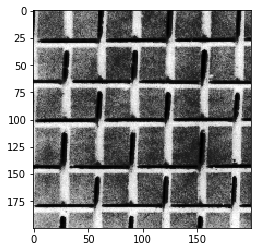

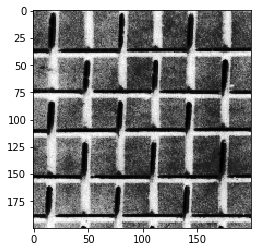

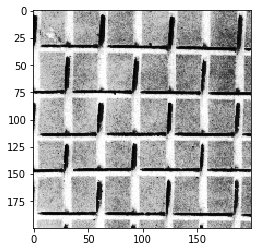

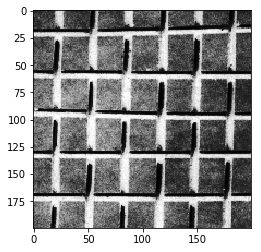

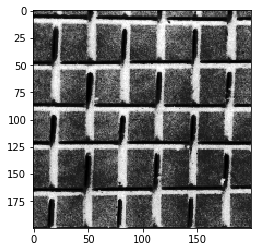

[None, None, None, None, None]

In [376]:
[plot(img) for img in x[probas_to_classes(y) == 1]]

In [11]:
classes = np.arange(0, 10)
x, y, num_classes = process_file_some_classes('Alexander_cls_train.csv', classes)

In [12]:
model = model_1(num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 198, 198, 64)      640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 97, 97, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 48, 48, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 46, 46, 256)       295168    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 256)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 135424)            0         
__________

In [13]:
batch_size = 128
epochs = 600
history = fit_generator_1(model, x, y, classes, batch_size, epochs=epochs)
test_1(model, classes, batch_size)

Epoch 1/600
1/0 [============================================================================] - 0s - loss: 5.1001 - acc: 0.1000 - val_loss: 5.0282 - val_acc: 0.1000
Epoch 2/600
1/0 [============================================================================] - 0s - loss: 5.0448 - acc: 0.1000 - val_loss: 4.9204 - val_acc: 0.1000
Epoch 3/600
1/0 [============================================================================] - 0s - loss: 4.9292 - acc: 0.1000 - val_loss: 4.7587 - val_acc: 0.1000
Epoch 4/600
1/0 [============================================================================] - 0s - loss: 4.7550 - acc: 0.1200 - val_loss: 4.6298 - val_acc: 0.1200
Epoch 5/600
1/0 [============================================================================] - 0s - loss: 4.6265 - acc: 0.1400 - val_loss: 4.5188 - val_acc: 0.2000
Epoch 6/600
1/0 [============================================================================] - 0s - loss: 4.5126 - acc: 0.1200 - val_loss: 4.4116 - val_acc: 0.1000
Epoc

1/0 [============================================================================] - 0s - loss: 2.4613 - acc: 0.2400 - val_loss: 2.8814 - val_acc: 0.1600
Epoch 51/600
1/0 [============================================================================] - 0s - loss: 2.4548 - acc: 0.2600 - val_loss: 2.7958 - val_acc: 0.1200
Epoch 52/600
1/0 [============================================================================] - 0s - loss: 2.2755 - acc: 0.3200 - val_loss: 3.0103 - val_acc: 0.1200
Epoch 53/600
1/0 [============================================================================] - 0s - loss: 2.3358 - acc: 0.3400 - val_loss: 2.9811 - val_acc: 0.1000
Epoch 54/600
1/0 [============================================================================] - 0s - loss: 2.2981 - acc: 0.3800 - val_loss: 3.1664 - val_acc: 0.1800
Epoch 55/600
1/0 [============================================================================] - 0s - loss: 2.2696 - acc: 0.3400 - val_loss: 2.9109 - val_acc: 0.1000
Epoch 56/60

1/0 [============================================================================] - 0s - loss: 1.6863 - acc: 0.6600 - val_loss: 3.1844 - val_acc: 0.2000
Epoch 100/600
1/0 [============================================================================] - 0s - loss: 1.8179 - acc: 0.5600 - val_loss: 2.7761 - val_acc: 0.2600
Epoch 101/600
1/0 [============================================================================] - 0s - loss: 1.5698 - acc: 0.7600 - val_loss: 2.7284 - val_acc: 0.2400
Epoch 102/600
1/0 [============================================================================] - 0s - loss: 1.8583 - acc: 0.5200 - val_loss: 3.0234 - val_acc: 0.2200
Epoch 103/600
1/0 [============================================================================] - 0s - loss: 1.6871 - acc: 0.6200 - val_loss: 3.1371 - val_acc: 0.2200
Epoch 104/600
1/0 [============================================================================] - 0s - loss: 1.9759 - acc: 0.5400 - val_loss: 2.6441 - val_acc: 0.2800
Epoch 

1/0 [============================================================================] - 0s - loss: 1.6125 - acc: 0.7000 - val_loss: 2.5511 - val_acc: 0.3600
Epoch 148/600
1/0 [============================================================================] - 0s - loss: 1.6739 - acc: 0.6600 - val_loss: 3.2977 - val_acc: 0.2000
Epoch 149/600
1/0 [============================================================================] - 0s - loss: 1.6121 - acc: 0.6200 - val_loss: 3.5600 - val_acc: 0.3400
Epoch 150/600
1/0 [============================================================================] - 0s - loss: 1.6696 - acc: 0.5800 - val_loss: 3.1900 - val_acc: 0.4000
Epoch 151/600
1/0 [============================================================================] - 0s - loss: 1.6853 - acc: 0.6600 - val_loss: 2.5897 - val_acc: 0.3600
Epoch 152/600
1/0 [============================================================================] - 0s - loss: 1.8334 - acc: 0.6200 - val_loss: 2.6699 - val_acc: 0.3400
Epoch 

1/0 [============================================================================] - 0s - loss: 1.8159 - acc: 0.7000 - val_loss: 2.8249 - val_acc: 0.4000
Epoch 196/600
1/0 [============================================================================] - 0s - loss: 1.4127 - acc: 0.8000 - val_loss: 2.6338 - val_acc: 0.4400
Epoch 197/600
1/0 [============================================================================] - 0s - loss: 1.4910 - acc: 0.7800 - val_loss: 3.0140 - val_acc: 0.3400
Epoch 198/600
1/0 [============================================================================] - 0s - loss: 1.4399 - acc: 0.7800 - val_loss: 3.2157 - val_acc: 0.3000
Epoch 199/600
1/0 [============================================================================] - 0s - loss: 1.6021 - acc: 0.6400 - val_loss: 2.8087 - val_acc: 0.4000
Epoch 200/600
1/0 [============================================================================] - 0s - loss: 1.4746 - acc: 0.7400 - val_loss: 2.6958 - val_acc: 0.4200
Epoch 

1/0 [============================================================================] - 0s - loss: 1.6108 - acc: 0.6800 - val_loss: 3.3147 - val_acc: 0.1400
Epoch 244/600
1/0 [============================================================================] - 0s - loss: 1.5021 - acc: 0.7600 - val_loss: 3.4532 - val_acc: 0.1600
Epoch 245/600
1/0 [============================================================================] - 0s - loss: 1.8627 - acc: 0.5600 - val_loss: 2.8905 - val_acc: 0.2400
Epoch 246/600
1/0 [============================================================================] - 0s - loss: 1.4734 - acc: 0.7600 - val_loss: 2.5601 - val_acc: 0.3200
Epoch 247/600
1/0 [============================================================================] - 0s - loss: 1.5884 - acc: 0.6400 - val_loss: 2.7208 - val_acc: 0.3000
Epoch 248/600
1/0 [============================================================================] - 0s - loss: 1.5270 - acc: 0.7200 - val_loss: 2.7413 - val_acc: 0.3000
Epoch 

1/0 [============================================================================] - 0s - loss: 1.5310 - acc: 0.7600 - val_loss: 3.2798 - val_acc: 0.3000
Epoch 292/600
1/0 [============================================================================] - 0s - loss: 1.5229 - acc: 0.6800 - val_loss: 2.7393 - val_acc: 0.3600
Epoch 293/600
1/0 [============================================================================] - 0s - loss: 1.4021 - acc: 0.7600 - val_loss: 2.4472 - val_acc: 0.4400
Epoch 294/600
1/0 [============================================================================] - 0s - loss: 1.3270 - acc: 0.7800 - val_loss: 2.7107 - val_acc: 0.4200
Epoch 295/600
1/0 [============================================================================] - 0s - loss: 1.3416 - acc: 0.7800 - val_loss: 3.6287 - val_acc: 0.2800
Epoch 296/600
1/0 [============================================================================] - 0s - loss: 1.6525 - acc: 0.7000 - val_loss: 4.0304 - val_acc: 0.2400
Epoch 

1/0 [============================================================================] - 0s - loss: 1.1749 - acc: 0.8400 - val_loss: 2.5997 - val_acc: 0.4400
Epoch 340/600
1/0 [============================================================================] - 0s - loss: 1.4881 - acc: 0.7400 - val_loss: 2.8286 - val_acc: 0.4800
Epoch 341/600
1/0 [============================================================================] - 0s - loss: 1.3896 - acc: 0.7200 - val_loss: 2.9715 - val_acc: 0.3800
Epoch 342/600
1/0 [============================================================================] - 0s - loss: 1.3518 - acc: 0.8400 - val_loss: 2.8315 - val_acc: 0.4000
Epoch 343/600
1/0 [============================================================================] - 0s - loss: 1.4047 - acc: 0.7200 - val_loss: 2.8696 - val_acc: 0.4000
Epoch 344/600
1/0 [============================================================================] - 0s - loss: 1.3926 - acc: 0.8600 - val_loss: 2.7325 - val_acc: 0.3800
Epoch 

1/0 [============================================================================] - 0s - loss: 1.3348 - acc: 0.8000 - val_loss: 2.7947 - val_acc: 0.3200
Epoch 388/600
1/0 [============================================================================] - 0s - loss: 1.2904 - acc: 0.8200 - val_loss: 2.4303 - val_acc: 0.4200
Epoch 389/600
1/0 [============================================================================] - 0s - loss: 1.3126 - acc: 0.8400 - val_loss: 2.5008 - val_acc: 0.4000
Epoch 390/600
1/0 [============================================================================] - 0s - loss: 1.5017 - acc: 0.7000 - val_loss: 3.1342 - val_acc: 0.2600
Epoch 391/600
1/0 [============================================================================] - 0s - loss: 1.2806 - acc: 0.8200 - val_loss: 3.5270 - val_acc: 0.3000
Epoch 392/600
1/0 [============================================================================] - 0s - loss: 1.2528 - acc: 0.8200 - val_loss: 3.2061 - val_acc: 0.3000
Epoch 

1/0 [============================================================================] - 0s - loss: 1.2846 - acc: 0.8000 - val_loss: 2.2284 - val_acc: 0.5200
Epoch 436/600
1/0 [============================================================================] - 0s - loss: 1.3420 - acc: 0.7200 - val_loss: 2.2895 - val_acc: 0.5000
Epoch 437/600
1/0 [============================================================================] - 0s - loss: 1.4793 - acc: 0.6600 - val_loss: 3.0120 - val_acc: 0.2600
Epoch 438/600
1/0 [============================================================================] - 0s - loss: 1.4238 - acc: 0.7200 - val_loss: 3.5674 - val_acc: 0.2200
Epoch 439/600
1/0 [============================================================================] - 0s - loss: 1.5914 - acc: 0.7400 - val_loss: 3.3146 - val_acc: 0.2000
Epoch 440/600
1/0 [============================================================================] - 0s - loss: 1.2567 - acc: 0.8200 - val_loss: 2.6806 - val_acc: 0.4000
Epoch 

1/0 [============================================================================] - 0s - loss: 1.3522 - acc: 0.8000 - val_loss: 2.8833 - val_acc: 0.3200
Epoch 484/600
1/0 [============================================================================] - 0s - loss: 1.2805 - acc: 0.7800 - val_loss: 2.6824 - val_acc: 0.3600
Epoch 485/600
1/0 [============================================================================] - 0s - loss: 1.4172 - acc: 0.7800 - val_loss: 2.5719 - val_acc: 0.3600
Epoch 486/600
1/0 [============================================================================] - 0s - loss: 1.3454 - acc: 0.7600 - val_loss: 2.6882 - val_acc: 0.2600
Epoch 487/600
1/0 [============================================================================] - 0s - loss: 1.4402 - acc: 0.7000 - val_loss: 2.8741 - val_acc: 0.2800
Epoch 488/600
1/0 [============================================================================] - 0s - loss: 1.5343 - acc: 0.6800 - val_loss: 3.0944 - val_acc: 0.1800
Epoch 

1/0 [============================================================================] - 0s - loss: 1.3894 - acc: 0.7000 - val_loss: 2.9736 - val_acc: 0.2800
Epoch 532/600
1/0 [============================================================================] - 0s - loss: 1.5101 - acc: 0.7800 - val_loss: 2.5710 - val_acc: 0.2600
Epoch 533/600
1/0 [============================================================================] - 0s - loss: 1.2013 - acc: 0.8400 - val_loss: 2.4802 - val_acc: 0.3400
Epoch 534/600
1/0 [============================================================================] - 0s - loss: 1.4976 - acc: 0.6600 - val_loss: 2.6543 - val_acc: 0.3400
Epoch 535/600
1/0 [============================================================================] - 0s - loss: 1.2096 - acc: 0.8000 - val_loss: 3.0512 - val_acc: 0.2600
Epoch 536/600
1/0 [============================================================================] - 0s - loss: 1.2512 - acc: 0.7800 - val_loss: 3.4102 - val_acc: 0.2200
Epoch 

1/0 [============================================================================] - 0s - loss: 1.3952 - acc: 0.8000 - val_loss: 2.8420 - val_acc: 0.3000
Epoch 580/600
1/0 [============================================================================] - 0s - loss: 1.1876 - acc: 0.8600 - val_loss: 2.8147 - val_acc: 0.3200
Epoch 581/600
1/0 [============================================================================] - 0s - loss: 1.0368 - acc: 0.8800 - val_loss: 2.6566 - val_acc: 0.3800
Epoch 582/600
1/0 [============================================================================] - 0s - loss: 1.1711 - acc: 0.8400 - val_loss: 2.3370 - val_acc: 0.4600
Epoch 583/600
1/0 [============================================================================] - 0s - loss: 1.5664 - acc: 0.6800 - val_loss: 2.3542 - val_acc: 0.4600
Epoch 584/600
1/0 [============================================================================] - 0s - loss: 1.1738 - acc: 0.8000 - val_loss: 2.6452 - val_acc: 0.4200
Epoch 

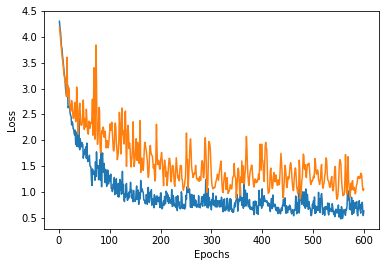

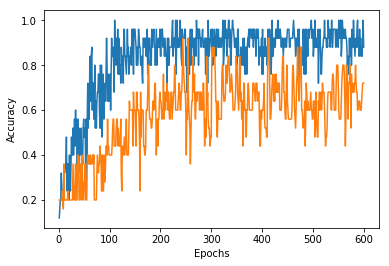

In [10]:
plot_history(history)

In [14]:
x_test, y_test, num_classes = process_file_some_classes('Alexander_cls_test2.csv', classes)
y_predict_classes = model.predict_classes(x_test, batch_size=32) + 1

50/50 [==============================] - 0s     


In [15]:
y_test_classes = probas_to_classes(y_test)
print(y_test_classes)

print(y_predict_classes)

[ 2 10  5  4  3  8  9  1  6  7  2 10  5  4  3  8  9  1  6  7  2 10  5  4  3
  8  9  1  6  7  2 10  5  4  3  8  9  1  6  7  2 10  5  4  3  8  9  1  6  7]
[ 7  6  7  4  7  6  7  6  6  7  4  6  5  4  6 10  7  1  6  7  4  6  7  4  6
 10  3  6  6  7  6  6  7  4  7  6  7  6  6  7  7  6  5  4  7 10  5  6  6  7]


In [16]:
y.shape

(50, 10)

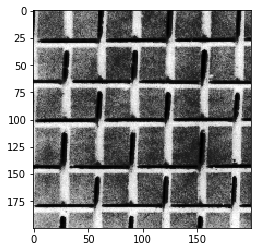

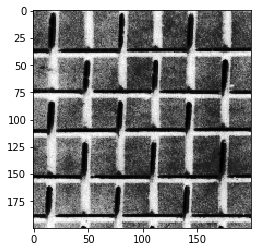

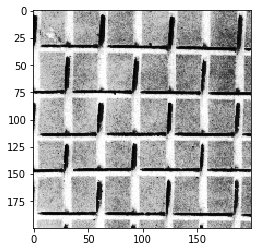

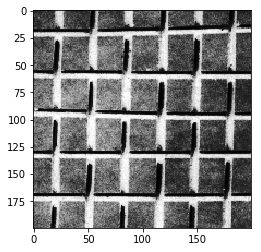

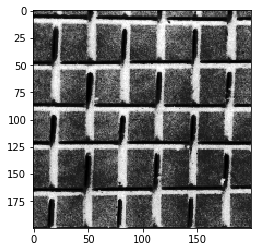

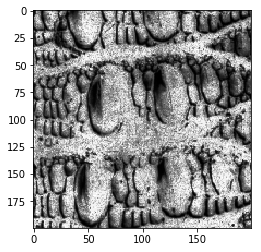

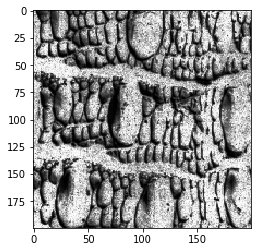

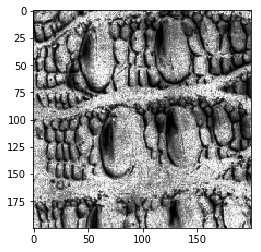

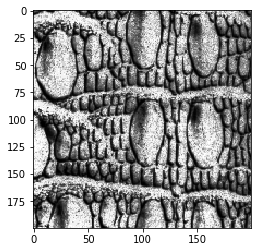

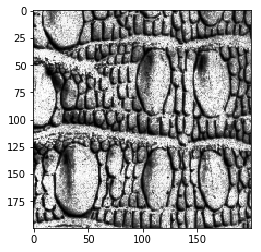

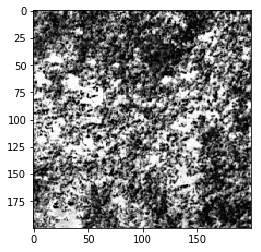

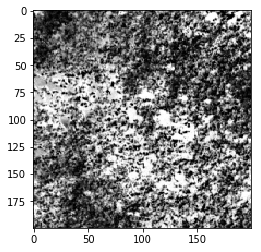

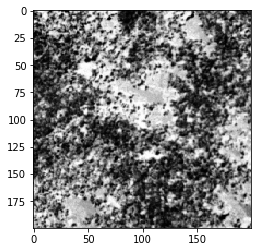

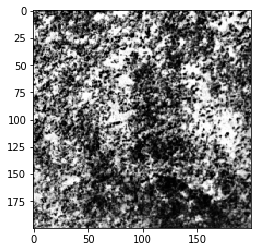

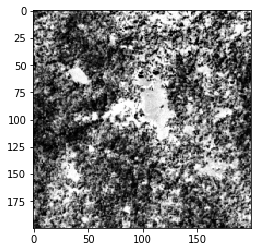

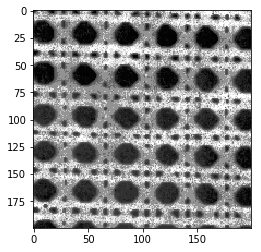

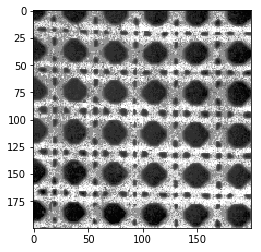

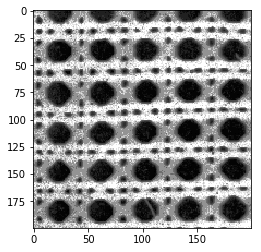

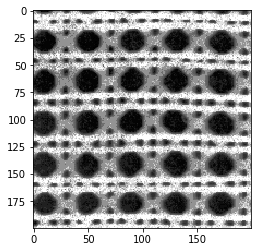

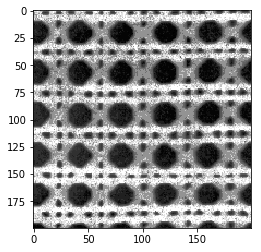

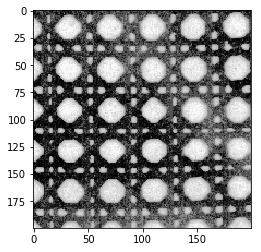

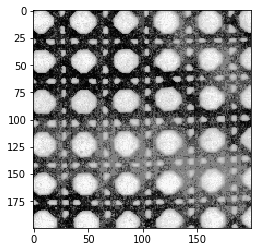

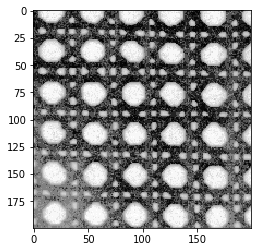

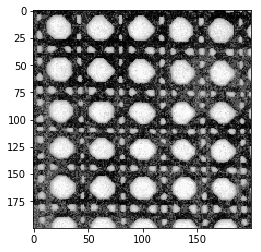

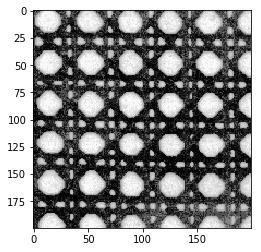

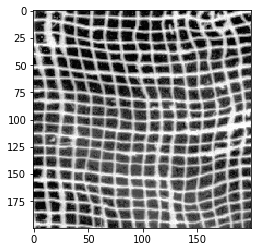

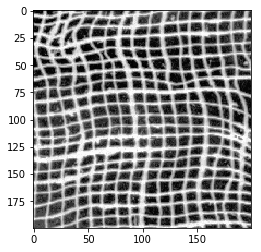

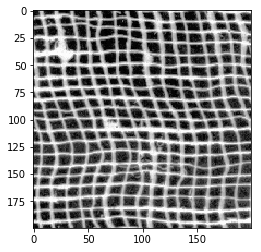

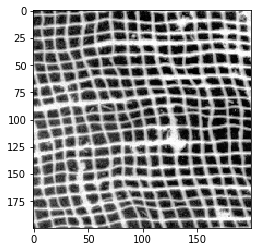

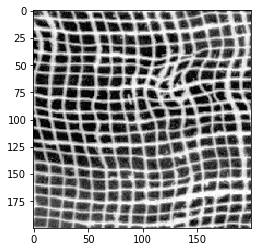

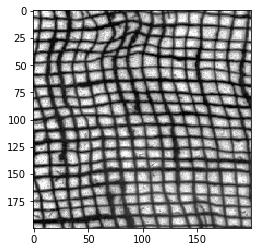

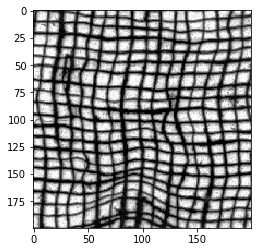

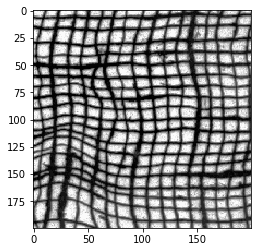

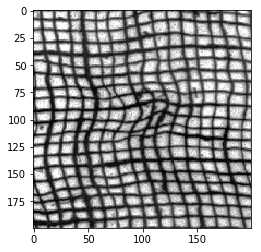

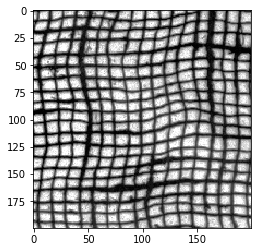

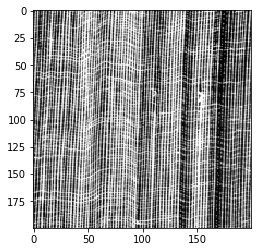

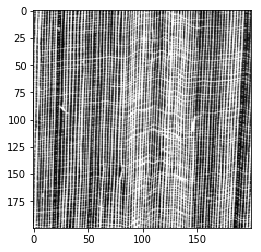

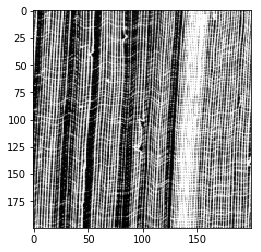

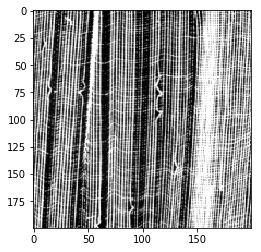

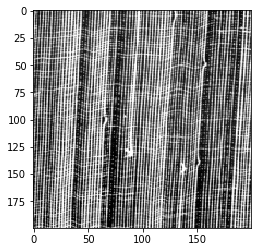

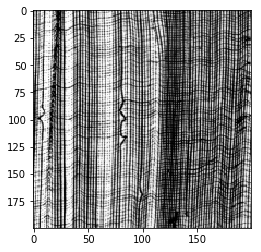

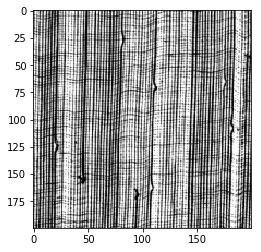

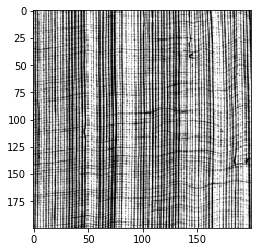

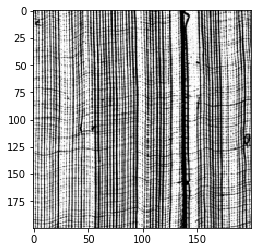

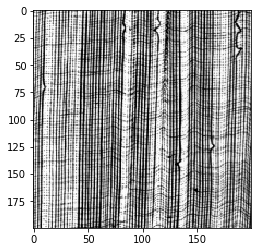

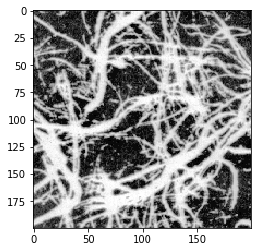

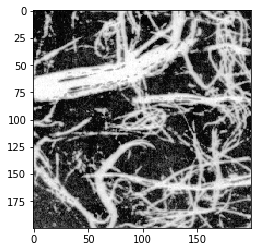

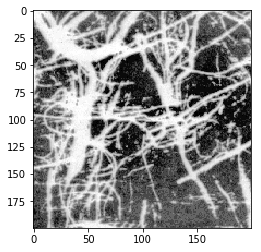

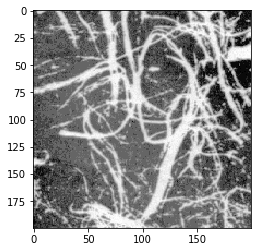

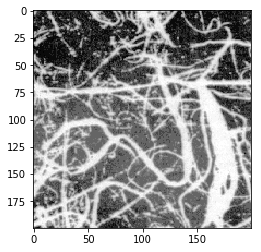

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
[plot(img) for img in x]

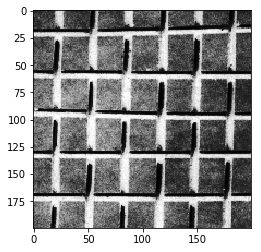

[None]

In [101]:
[plot(img) for img in x[y_predict_classes == 2]]

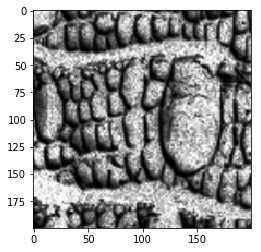

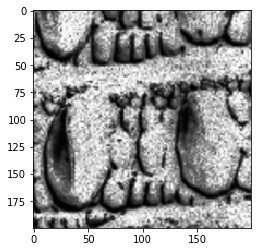

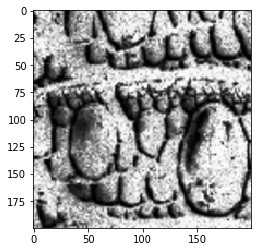

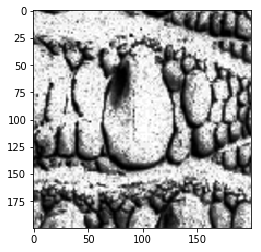

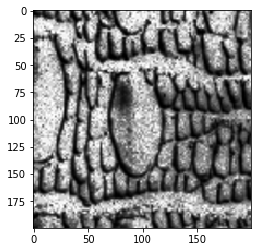

[None, None, None, None, None]

In [103]:
[plot(img) for img in x_test[y_test_classes == 2]]

In [18]:
np.unique(np.argmax(y_predict, axis=1))

NameError: name 'y_predict' is not defined

In [ ]:
model = Sequential()
# input: 200x200 grayscale images -> (200, 200, 1) tensors.
# this applies 8 convolution filters of size 3x3 each.
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu', input_shape=(200, 200, 1)))
model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(Conv2D(128, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(Conv2D(256, (3, 3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(128, (2, 2), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.25))

# model.add(Conv2D(512, (2, 2), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
# model.add(Dense(1024, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01), activation='softmax'), )
model.add(Dropout(0.5))

# sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# model.fit(x, y, batch_size=8, epochs=10, validation_data=(x_train, y_train))
model.fit(x, y, batch_size=32, epochs=500)

In [ ]:
x_test, y_test, num_classes = process_file('Alexander_cls_train.csv')

In [ ]:
batch_size = 20
model.fit_generator(datagen.flow(x, y, batch_size=batch_size),
                    steps_per_epoch=len(x) / batch_size * 10, epochs=500, use_multiprocessing=True, workers=20)

In [ ]:
test_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True
)

test_datagen.fit(x)

test_paths = ['Alexander_cls_train.csv',
             'Alexander_cls_test.csv',
             'Alexander_cls_test1.csv',
             'Alexander_cls_test2.csv',
             'Alexander_cls_test3.csv',
             'Alexander_cls_test4.csv']

batch_size = 32

for test_path in test_paths:
    x_test, y_test, num_classes = process_file(test_path)
    score = model.evaluate_generator(test_datagen.flow(x_test, y_test, batch_size=batch_size), steps=len(x_test) / batch_size)
    print(test_path + ' : ' + ', '.join(str(x) for x in score))

In [ ]:
model.evaluate(x, y, batch_size=32)

In [ ]:
y_predict = model.predict(x_test, batch_size=32)

In [ ]:
y_predict.shape

In [ ]:
np.argmax(y_test, axis=1).shape

In [ ]:
np.sum(np.argmax(y_predict, axis=1) == np.argmax(y_test, axis=1))/y_predict.shape[0]

In [ ]:
np.unique(np.argmax(y_predict, axis=1))

In [ ]:
model.summary()

In [ ]:
# спросить про 500 samples на класс (хорошо, но можно оверфитнуться)
# когда 50 сэмплов хорошо, обычно плохо